Running...
Done.



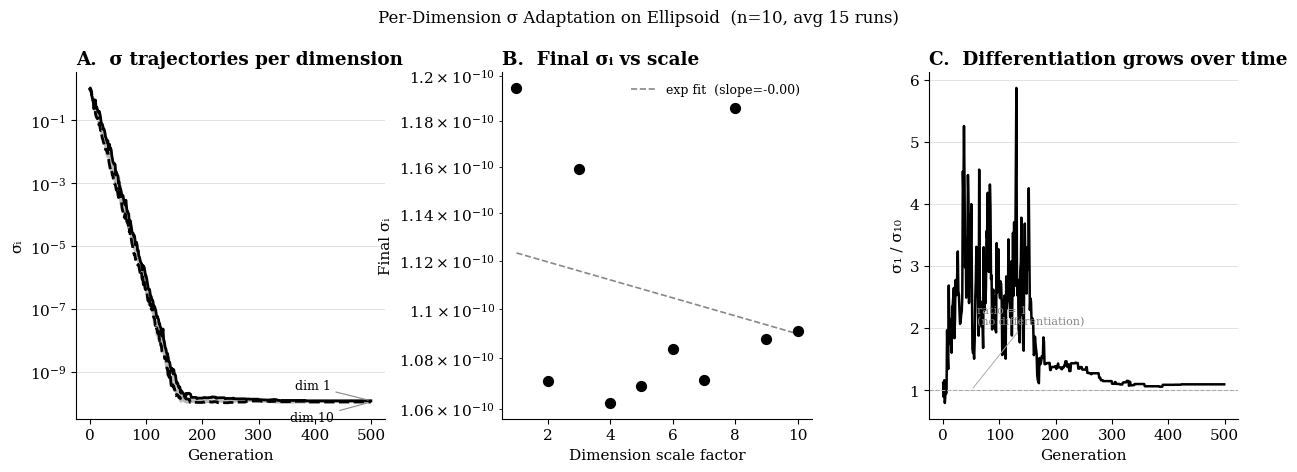

Plot 1 saved.


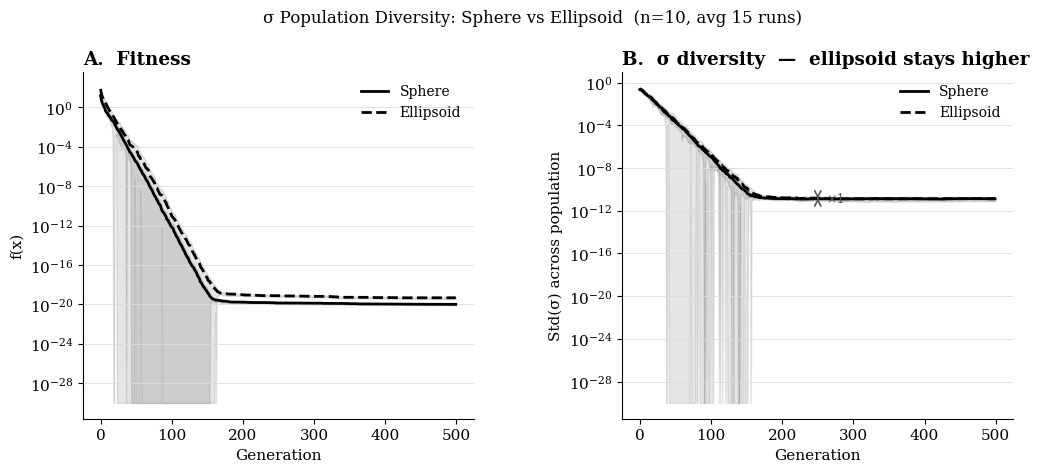

Plot 2 saved.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams.update({
    "font.family":       "serif",
    "font.size":         11,
    "axes.spines.top":   False,
    "axes.spines.right": False,
    "axes.linewidth":    0.8,
    "grid.color":        "#dddddd",
    "grid.linewidth":    0.6,
    "xtick.direction":   "out",
    "ytick.direction":   "out",
})

# ══════════════════════════════════════════════════════════════════════════════
# Functions & ES
# ══════════════════════════════════════════════════════════════════════════════
def sphere(x):
    return np.sum(x**2)

def ellipsoid(x):
    return np.sum(np.arange(1, len(x)+1) * x**2)

def self_adaptive_es(fitness_fn, dim=10, mu=15, lmbda=100,
                     generations=500, sigma_init=1.0):
    tau_g = 1.0 / np.sqrt(2 * dim)
    tau_l = 1.0 / np.sqrt(2 * np.sqrt(dim))

    population = [
        (np.random.uniform(-5, 5, dim), np.full(dim, sigma_init))
        for _ in range(mu)
    ]

    fitness_hist  = []
    sigma_dim_hist = []    # per-dim σ of best individual
    sigma_div_hist = []    # std of mean-σ across population

    for _ in range(generations):
        offspring = []
        for _ in range(lmbda):
            i1, i2 = np.random.randint(mu, size=2)
            x1, s1 = population[i1]
            x2, s2 = population[i2]
            xc = 0.5*(x1+x2)
            sc = 0.5*(s1+s2) * np.exp(tau_g*np.random.randn()
                                       + tau_l*np.random.randn(dim))
            sc = np.maximum(sc, 1e-10)
            xc = xc + sc * np.random.randn(dim)
            offspring.append((xc, sc))

        pool      = population + offspring
        fits      = np.array([fitness_fn(p[0]) for p in pool])
        top       = np.argsort(fits)[:mu]
        population = [pool[i] for i in top]

        fitness_hist.append(fits[top[0]])
        sigma_dim_hist.append(population[0][1].copy())
        pop_sigmas = [np.mean(p[1]) for p in population]
        sigma_div_hist.append(np.std(pop_sigmas))

    return (np.array(fitness_hist),
            np.array(sigma_dim_hist),
            np.array(sigma_div_hist))

# ══════════════════════════════════════════════════════════════════════════════
# Run
# ══════════════════════════════════════════════════════════════════════════════
DIM, MU, LMBDA, GENS, N_RUNS = 10, 15, 100, 500, 15
np.random.seed(42)

print("Running...")
e_fh, e_sdh, e_div = [], [], []
s_fh, s_div        = [], []

for _ in range(N_RUNS):
    fh, sdh, div = self_adaptive_es(ellipsoid, dim=DIM, mu=MU,
                                     lmbda=LMBDA, generations=GENS)
    e_fh.append(fh); e_sdh.append(sdh); e_div.append(div)

    fh, _, div = self_adaptive_es(sphere, dim=DIM, mu=MU,
                                   lmbda=LMBDA, generations=GENS)
    s_fh.append(fh); s_div.append(div)

e_fh  = np.array(e_fh);  e_sdh = np.array(e_sdh); e_div = np.array(e_div)
s_fh  = np.array(s_fh);  s_div = np.array(s_div)

sdh_mean = e_sdh.mean(0)   # (gens, dim)
gens     = np.arange(GENS)
scales   = np.arange(1, DIM+1)
print("Done.\n")


# ══════════════════════════════════════════════════════════════════════════════
# PLOT 1 — Per-dimension σ
# Three panels: trajectories | final σ vs scale | ratio proof
# ══════════════════════════════════════════════════════════════════════════════
fig = plt.figure(figsize=(15, 4.5))
gs  = gridspec.GridSpec(1, 3, wspace=0.38)

# ── Panel A: trajectories, grey palette, highlight first & last ───────────────
ax = fig.add_subplot(gs[0])

# all middle dims in light grey
for i in range(1, DIM-1):
    ax.semilogy(gens, sdh_mean[:, i], color="#bbbbbb", linewidth=0.9, zorder=1)

# dim 1 (easiest) and dim 10 (hardest) in black, labelled
ax.semilogy(gens, sdh_mean[:, 0],  color="black", linewidth=2.0,
            zorder=3, label="dim 1  (scale=1, easiest)")
ax.semilogy(gens, sdh_mean[:, -1], color="black", linewidth=2.0,
            zorder=3, linestyle="--", label="dim 10 (scale=10, hardest)")

# end-point annotations
ax.annotate("dim 1",  xy=(GENS-1, sdh_mean[-1, 0]),
            xytext=(-55, 8), textcoords="offset points",
            fontsize=9, color="black",
            arrowprops=dict(arrowstyle="-", color="#888888", lw=0.8))
ax.annotate("dim 10", xy=(GENS-1, sdh_mean[-1, -1]),
            xytext=(-58, -14), textcoords="offset points",
            fontsize=9, color="black",
            arrowprops=dict(arrowstyle="-", color="#888888", lw=0.8))

ax.set_xlabel("Generation")
ax.set_ylabel("σᵢ")
ax.set_title("A.  σ trajectories per dimension", loc="left", fontweight="bold")
ax.grid(True, which="major", axis="y")

# ── Panel B: final σ vs scale — clean scatter + trend ────────────────────────
ax = fig.add_subplot(gs[1])

final_sigma = sdh_mean[-1, :]
ax.scatter(scales, final_sigma, color="black", s=50, zorder=3)

# log-linear fit
logfit = np.polyfit(scales, np.log(final_sigma), 1)
fit_y  = np.exp(np.polyval(logfit, scales))
ax.plot(scales, fit_y, color="#888888", linewidth=1.2, linestyle="--",
        label=f"exp fit  (slope={logfit[0]:.2f})")

ax.set_yscale("log")
ax.set_xlabel("Dimension scale factor")
ax.set_ylabel("Final σᵢ")
ax.set_title("B.  Final σᵢ vs scale", loc="left", fontweight="bold")
ax.legend(fontsize=9, frameon=False)
ax.grid(True, which="major", axis="y")

# ── Panel C: ratio σ_1 / σ_10 over time — does differentiation grow? ─────────
ax = fig.add_subplot(gs[2])

ratio = sdh_mean[:, 0] / sdh_mean[:, -1]
ax.plot(gens, ratio, color="black", linewidth=1.8)
ax.axhline(1.0, color="#aaaaaa", linewidth=0.8, linestyle="--")
ax.annotate("ratio = 1\n(no differentiation)", xy=(50, 1.0),
            xytext=(60, ratio.max()*0.35), fontsize=8, color="#888888",
            arrowprops=dict(arrowstyle="-", color="#aaaaaa", lw=0.7))

ax.set_xlabel("Generation")
ax.set_ylabel("σ₁ / σ₁₀")
ax.set_title("C.  Differentiation grows over time", loc="left", fontweight="bold")
ax.grid(True, which="major", axis="y")

fig.suptitle("Per-Dimension σ Adaptation on Ellipsoid  (n=10, avg 15 runs)",
             fontsize=12, y=1.02)

plt.show()
plt.close()
print("Plot 1 saved.")


# ══════════════════════════════════════════════════════════════════════════════
# PLOT 2 — σ diversity: sphere vs ellipsoid
# Two panels: fitness | diversity  — same x axis, direct comparison
# ══════════════════════════════════════════════════════════════════════════════
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharey=False)
fig.subplots_adjust(wspace=0.38)

e_fh_m = e_fh.mean(0);  e_fh_s = e_fh.std(0)
s_fh_m = s_fh.mean(0);  s_fh_s = s_fh.std(0)
e_div_m = e_div.mean(0); e_div_s = e_div.std(0)
s_div_m = s_div.mean(0); s_div_s = s_div.std(0)

# ── Panel A: fitness ──────────────────────────────────────────────────────────
ax = axes[0]
ax.semilogy(gens, s_fh_m, color="black",   linewidth=2.0, label="Sphere")
ax.semilogy(gens, e_fh_m, color="black",   linewidth=2.0, linestyle="--",
            label="Ellipsoid")
ax.fill_between(gens, np.maximum(s_fh_m - s_fh_s, 1e-30), s_fh_m + s_fh_s,
                alpha=0.10, color="black")
ax.fill_between(gens, np.maximum(e_fh_m - e_fh_s, 1e-30), e_fh_m + e_fh_s,
                alpha=0.10, color="black")
ax.set_xlabel("Generation")
ax.set_ylabel("f(x)")
ax.set_title("A.  Fitness", loc="left", fontweight="bold")
ax.legend(frameon=False, fontsize=10)
ax.grid(True, which="major", axis="y")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# ── Panel B: σ diversity ──────────────────────────────────────────────────────
ax = axes[1]
ax.semilogy(gens, np.maximum(s_div_m, 1e-30), color="black",
            linewidth=2.0, label="Sphere")
ax.semilogy(gens, np.maximum(e_div_m, 1e-30), color="black",
            linewidth=2.0, linestyle="--", label="Ellipsoid")
ax.fill_between(gens,
                np.maximum(s_div_m - s_div_s, 1e-30),
                np.maximum(s_div_m + s_div_s, 1e-30),
                alpha=0.10, color="black")
ax.fill_between(gens,
                np.maximum(e_div_m - e_div_s, 1e-30),
                np.maximum(e_div_m + e_div_s, 1e-30),
                alpha=0.10, color="black")

# gap annotation — the key insight
mid = GENS // 2
gap = e_div_m[mid] / s_div_m[mid]
ax.annotate("", xy=(mid, e_div_m[mid]), xytext=(mid, s_div_m[mid]),
            arrowprops=dict(arrowstyle="<->", color="#555555", lw=1.2))
ax.text(mid + 12, np.sqrt(e_div_m[mid] * s_div_m[mid]),
        f"×{gap:.0f}", fontsize=9, color="#555555", va="center")

ax.set_xlabel("Generation")
ax.set_ylabel("Std(σ) across population")
ax.set_title("B.  σ diversity  —  ellipsoid stays higher",
             loc="left", fontweight="bold")
ax.legend(frameon=False, fontsize=10)
ax.grid(True, which="major", axis="y")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.suptitle("σ Population Diversity: Sphere vs Ellipsoid  (n=10, avg 15 runs)",
             fontsize=12, y=1.02)

plt.show()
plt.close()
print("Plot 2 saved.")